In [1]:
# !pip install matplotlib tqdm numpy

In [2]:
import argparse
from pathlib import Path
import multiprocessing
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from multiprocessor.scheduler import MultiprocessorSchedulerType
from multiprocessor.partitioner import FirstFit, NextFit, BestFit, WorstFit

# self-written modules
from utils.metrics import MultiprocessorFeasibility, calculate_success_rate
from utils.plotters import plot_average_execution_time
from utils.parse import parse_task_file
from multiprocessor.feasibility.review import review_task_sets_in_parallel_multi

import numpy as np


In [3]:
# calculate feasibility ratio by parameter
def calculate_feasibility_ratio(schedule_stats):
    feasible = schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SHORTCUT, 0) + \
               schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SIMULATION, 0)
    total = feasible + schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SHORTCUT, 0) + \
            schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SIMULATION, 0)
    if total == 0:
        return 0
    return feasible / total * 1.0

In [4]:
# process task sets for Plot 1 and 2 (by number of tasks)

def average_execution_time_by_workers(config, folder_name):
    """
    Process task sets organized by number of tasks (like in 4-tasks, 10-tasks).
    """
    # subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name))
    # print(subfolders)
    execution_times = []

    workers = config["number_of_workers"]

    for worker_quantity in workers:
        start_time = time()

        print(f"Executing with: {worker_quantity} workers.")
        #for subfolder in subfolders:
        #print(f"Subfolder: {subfolder}")
        num_tasks = 100
        #print(f"\nProcessing {num_tasks} tasks in {subfolder}")
        print(f"Evaluating algorithm: {config["alg"].name}")
        schedule_stats = review_task_sets_in_parallel_multi(algorithm=config["alg"],
                                                        folder_name=folder_name,
                                                        num_processors=config["processors"],
                                                        #num_clusters=config["clusters"],
                                                        heuristic=config["heuristic"],
                                                        number_of_workers=worker_quantity)
            # success_rate = calculate_success_rate(schedule_stats) #TODO execution time
            # execution_times[num_tasks] = success_rate
        end_time = time() - start_time
        print(end_time)

        execution_times.append(
            {
                "workers": worker_quantity,
                "time": end_time
            }
        )

    return execution_times

In [5]:
def get_workers_range(from_val, to_val):
    return list(range(from_val, to_val + 1))

config_to_evaluate = {
        "alg": MultiprocessorSchedulerType.PARTITIONED_EDF,
        "heuristic": BestFit(decreasing_utilisation=True, verbose=False),
        "sorting": 'du',
        "processors": 8,
        #"clusters": 4,
        "number_of_workers": get_workers_range(1, 32)
    }
# python3 main.py tasksets-multiprocessor 8 partitioned -H bf -s du

results = average_execution_time_by_workers(config=config_to_evaluate, folder_name="tasksets-multiprocessor/")


Executing with: 1 workers.
Evaluating algorithm: PARTITIONED_EDF
Number of workers for the task sets: 0
Number of workers for the algorithms: 1
Total files considered: 1000
0.38321900367736816
Executing with: 2 workers.
Evaluating algorithm: PARTITIONED_EDF
Number of workers for the task sets: 0
Number of workers for the algorithms: 2
Total files considered: 1000
0.41044044494628906
Executing with: 3 workers.
Evaluating algorithm: PARTITIONED_EDF
Number of workers for the task sets: 0
Number of workers for the algorithms: 3
Total files considered: 1000
0.3766498565673828
Executing with: 4 workers.
Evaluating algorithm: PARTITIONED_EDF
Number of workers for the task sets: 0
Number of workers for the algorithms: 4
Total files considered: 1000
0.40911197662353516
Executing with: 5 workers.
Evaluating algorithm: PARTITIONED_EDF
Number of workers for the task sets: 0
Number of workers for the algorithms: 5
Total files considered: 1000
0.38377976417541504
Executing with: 6 workers.
Evaluatin

Time taken for 1 workers: 0.38321900367736816
Time taken for 2 workers: 0.41044044494628906
Time taken for 3 workers: 0.3766498565673828
Time taken for 4 workers: 0.40911197662353516
Time taken for 5 workers: 0.38377976417541504
Time taken for 6 workers: 0.4079582691192627
Time taken for 7 workers: 0.37610626220703125
Time taken for 8 workers: 0.4202868938446045
Time taken for 9 workers: 0.299393892288208
Time taken for 10 workers: 0.246809720993042
Time taken for 11 workers: 0.27144551277160645
Time taken for 12 workers: 0.2983396053314209
Time taken for 13 workers: 0.30913805961608887
Time taken for 14 workers: 0.29480719566345215
Time taken for 15 workers: 0.30324554443359375
Time taken for 16 workers: 0.3050708770751953
Time taken for 17 workers: 0.2774479389190674
Time taken for 18 workers: 0.30951786041259766
Time taken for 19 workers: 0.3286147117614746
Time taken for 20 workers: 0.31545352935791016
Time taken for 21 workers: 0.3191845417022705
Time taken for 22 workers: 0.33466

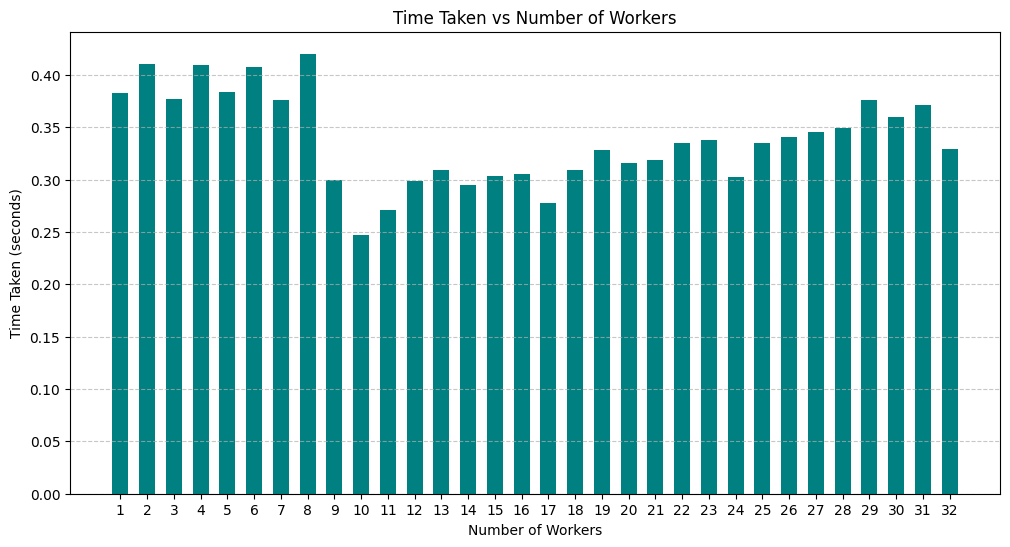

In [6]:
for result in results:
    print(f"Time taken for {result["workers"]} workers: {result["time"]}")

workers = [result["workers"] for result in results]
times = [result["time"] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(workers, times, color='teal', width=0.6)
plt.xlabel('Number of Workers')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken vs Number of Workers')
plt.xticks(workers)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()